In [17]:
from astropy.io import fits
import numpy as np
import pandas as pd
import scipy.stats as sps
import matplotlib.pyplot as plt
from tabulate import tabulate
import scipy.integrate as spint
'''Karan Kumar 14906619'''

'Karan Kumar 14906619'

In [2]:
dr3stars = fits.open('gaiadr3_cluster_stars.fits')
dr3stars.info()
#print(dr3stars[1].columns)
stars = pd.DataFrame(dr3stars[1].data)
stars['Name'] = stars['Name'].str.strip()

Filename: gaiadr3_cluster_stars.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      93   ()      
  1  members.dat    1 TableHDU       331   1291929R x 56C   [A20, I4, I19, I1, F10.8, F12.8, F10.8, F12.8, F10.8, F12.8, E11.4, E11.4, F10.8, E11.4, F10.8, E11.4, F10.8, F11.8, F11.8, E11.4, E11.4, E11.4, E11.4, E11.4, E11.4, I2, F12.8, F10.7, F11.8, F10.8, F19.8, F16.8, F18.8, F17.8, F18.8, F17.8, F10.7, F10.7, F10.7, E11.4, E11.4, E11.4, E9.3, F12.8, F4.1, F6.1, F5.1, F11.7, F11.8, F6.1, F12.7, F13.8, F5.1, A13, I1, I1]   


In [3]:
stars.columns


Index(['Name', 'ID', 'GaiaDR3', 'inrt', 'Prob', 'RAdeg', 'e_RAdeg', 'DEdeg',
       'e_DEdeg', 'GLON', 'GLAT', 'pmRA', 'e_pmRA', 'pmDE', 'e_pmDE', 'Plx',
       'e_Plx', 'pscol', 'e_pscol', 'PlxpmRACor', 'PlxpmDECor', 'pmRApmDECor',
       'PlxpscolCor', 'pmRApscolCor', 'pmDEpscolCor', 'Solved', 'ELAT',
       'nueff', 'RUWE', 'FidelityV1', 'FG', 'e_FG', 'FBP', 'e_FBP', 'FRP',
       'e_FRP', 'Gmag', 'BPmag', 'RPmag', 'BP-RP', 'BP-G', 'G-RP', 'RV',
       'e_RV', 'n_RV', 'o_RV', 'o_RVd', 'GRVSmag', 'e_GRVSmag', 'o_GRVSmag',
       'Vbroad', 'e_Vbroad', 'o_Vbroad', 'VarFlag', 'NSS', 'RVS'],
      dtype='object')

Filter stars by high proability P > 0.8

In [4]:
stars_hiprob = stars[stars.Prob > 0.8]
clusters_hiprob = stars_hiprob.groupby(['Name']).size().reset_index(name='count')
clusters_sd_hiprob = stars_hiprob.groupby(['Name']).std(numeric_only=True).reset_index()

In [5]:
def per_cluster(hiprob_data):
    '''Calculate 6 parameters of  cluster
    n - number of stars in a cluster
    omega- mean parallax of the cluster
    sigma - standard deviation of the paralax
    size - size of cluster
    mPM - mean proper motion of cluster
    sdPM - standard deviaion of the propermotion'''
    
    #find the unique cluster names in the dataframe
    filtered_dataframe = pd.DataFrame()
   #group each cluster by its name
    #all operations should applied on this variable name
    clusters = hiprob_data.groupby('Name') #so i don't have to keep writing this
    
    n  = clusters.size()
    filtered_dataframe['Counts'] = n

    plx_method = clusters['Plx'].mean()
    filtered_dataframe['Mean plx'] = plx_method

    plx_std = clusters['Plx'].std(numeric_only=True)
    filtered_dataframe['Plx std'] = plx_std

    size = np.sqrt(clusters['RAdeg'].std()**2  + clusters['DEdeg'].std()**2)
    filtered_dataframe["Cluster Size"] = size

    proper_motion_mag = (clusters['pmRA'].mean())**2 + (clusters['pmDE'].mean())**2
   # proper_motion_mag = #clusters['pmRA'].transform(lambda x:x**2)  + clusters['pmDE'].transform(lambda y:y**2)
    proper_motion_mag = np.sqrt(proper_motion_mag)
    filtered_dataframe["Mean PM" ] = proper_motion_mag

    proper_motion_std = np.sqrt(clusters['pmRA'].std()**2  + clusters['pmDE'].std()**2)
    filtered_dataframe["PM Std"] = proper_motion_std
    
    return filtered_dataframe
cluster_analysis = per_cluster(stars_hiprob)
#i get a warning becuase im running operations on a copy of a original dataframe, but it still works
cluster_analysis


,Counts,Mean plx,Plx std,Cluster Size,Mean PM,PM Std
Name,,,,,,
1636-283,30,0.126939,0.034519,0.050512,6.650466,0.240161
ADS_16795,41,4.759659,0.101591,5.438194,18.871288,1.810880
AH03_J0748+26.9,28,0.210004,0.017010,0.045579,4.025658,0.048521
ASCC_100,87,2.748023,0.091920,1.240143,3.863448,0.557090
ASCC_101,149,2.517671,0.088908,1.027157,1.595839,0.444430
...,...,...,...,...,...,...
vdBergh_152,25,2.674800,0.029313,0.886879,5.349199,0.444215
vdBergh_80,93,1.001419,0.053363,0.425505,3.299538,0.375063
vdBergh_83,92,1.041742,0.095341,0.347059,4.355737,0.277022


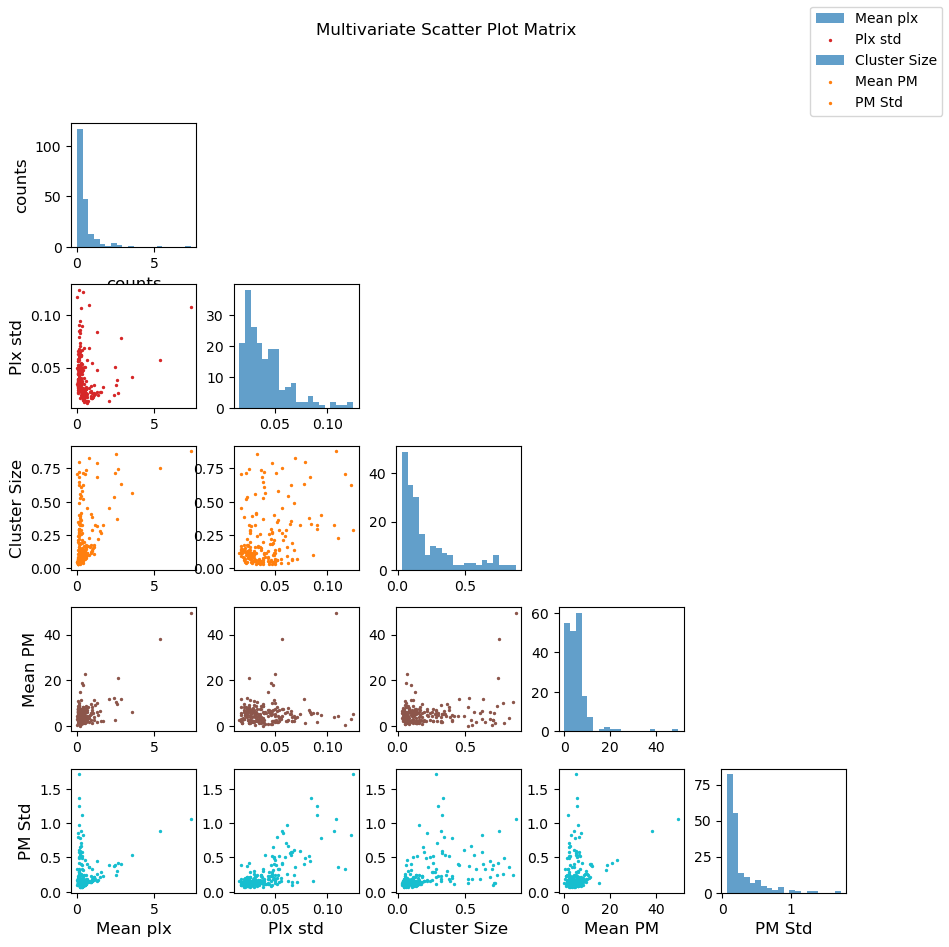

In [6]:
def scatter_matrix(cluster):
    '''Create a mulitvariate matrix of a dataframe of clusters
    
     i took all of this code from my first assignment submission
     and modified it to read the data for this assignment.

     input:
     cluster- dataframe of star clusters

     variables:
     data - df column, parameters to plot
     labels- axes labels, also related to parameters to plot
     return
     multivariate scatter matrix of parameters from data 
    '''
    
    counts = 200
    max_val = 1.0 
    #filter clusters by counts and size
    cluster = cluster[cluster['Counts'] > 200]
    cluster = cluster[cluster['Cluster Size'] < 1.0]
    #ignore counts column
    labels= cluster.columns[1:] 
    data = [cluster['Mean plx'], cluster['Plx std'], cluster['Cluster Size'], cluster['Mean PM'], cluster['PM Std']]
    ndims = len(data)
    fig, axes = plt.subplots(5,5,figsize=(10,10))
    fig.subplots_adjust(wspace=0.3,hspace=0.3)
    fig.suptitle("Multivariate Scatter Plot Matrix")
    colors = ['tab:blue', 'tab:red', 'tab:orange', 'tab:brown', 'tab:cyan']
    for i in range(ndims): ## y dimension of grid
        for j in range(ndims): ## x dimension of grid
            if i == j:
                axes[i,j].hist(data[i], bins=20,alpha=0.7,)
            elif i > j:
                axes[i,j].scatter(data[j], data[i],s=2, color=colors[i])
            else:
                axes[i,j].axis('off')
            if j == 0:
                if i == j:
                    axes[i,j].set_xlabel('counts',fontsize=12)
                    axes[i,j].set_ylabel('counts',fontsize=12)
                else:
                    axes[i,j].set_ylabel(labels[i],fontsize=12)
            if i == 4:
                axes[i,j].set_xlabel(labels[j],fontsize=12)    
    fig.legend(labels=labels)
    plt.show()
    return cluster
cluster_analysis = scatter_matrix(cluster_analysis)

# Visual Correlations
Here im just looking for linear trends by eye starting from the bottom row, looking up <br>
Mean plx and Mean PM, Cluster Size <br>
Plx std and PM std, Mean PM <br>
Cluster size and PM std, Mean PM

In [7]:
cluster_analysis# filtered clusters

,Counts,Mean plx,Plx std,Cluster Size,Mean PM,PM Std
Name,,,,,,
BH_131,227,0.125637,0.046214,0.221680,6.536827,0.154404
BH_140,338,0.190195,0.043486,0.127424,14.897046,0.129645
BH_66,355,0.123089,0.044962,0.180838,5.470541,0.229493
Berkeley_36,217,0.217359,0.065872,0.063243,1.967901,0.099389
Berkeley_39,211,0.226982,0.038289,0.045639,2.371439,0.068647
...,...,...,...,...,...,...
UBC_461,231,0.298768,0.031775,0.419239,4.096675,0.109858
UBC_517,256,0.405671,0.022682,0.716871,5.685520,0.127498
UBC_600,390,0.171171,0.039550,0.721515,1.191558,0.134289


I've filtered down to 198 clusters

In [8]:
def correlation(df_col1, df_col2):
    '''Calculate a pearson r and spearman rho correlation' for two dataframe columns
    '''
    r_val, p_val_r = sps.pearsonr(df_col1, df_col2)
    rho_val, p_val_rho = sps.spearmanr(df_col1, df_col2)
    return r_val, p_val_r, rho_val, p_val_rho

#i did the enumerate loop and asked chatgpt how to print everything to 4 sig digits

for i, cols1 in enumerate(cluster_analysis.columns[1:]): #skip counts column
    for j, cols2 in enumerate(cluster_analysis.columns[1:]):
        if i < j :
            pearson_corr, pearson_p_value, spearman_corr, spearman_p_value = correlation(cluster_analysis[cols1], cluster_analysis[cols2])
            print(f"{cols1} vs {cols2}: Pearson Correlation = {pearson_corr:.4f} (p-value = {pearson_p_value}), Spearman Correlation = {spearman_corr:.4f} (p-value = {spearman_p_value})")
# spearman_result = cluster_analysis.corr(method='spearman',  numeric_only=True)
# spearman_result['Blah'] = 3


Mean plx vs Plx std: Pearson Correlation = 0.0476 (p-value = 0.5053546796704824), Spearman Correlation = -0.3762 (p-value = 4.712016719689901e-08)
Mean plx vs Cluster Size: Pearson Correlation = 0.4766 (p-value = 1.275929198033422e-12), Spearman Correlation = 0.3736 (p-value = 5.8970560488021756e-08)
Mean plx vs Mean PM: Pearson Correlation = 0.6685 (p-value = 5.222065852850052e-27), Spearman Correlation = 0.0513 (p-value = 0.4729721146639403)
Mean plx vs PM Std: Pearson Correlation = 0.2285 (p-value = 0.0012062465572070208), Spearman Correlation = 0.0252 (p-value = 0.7242272544725276)
Plx std vs Cluster Size: Pearson Correlation = 0.3413 (p-value = 8.621711563390255e-07), Spearman Correlation = 0.2088 (p-value = 0.003160198292861663)
Plx std vs Mean PM: Pearson Correlation = 0.1291 (p-value = 0.06980530934800966), Spearman Correlation = -0.0134 (p-value = 0.8513928555765554)
Plx std vs PM Std: Pearson Correlation = 0.7130 (p-value = 4.7609372509091034e-32), Spearman Correlation = 0.60

You can improve the situation by performing the tests on log-transformed data (i.e. on the
logarithm of the quantities instead of the original values). Why should this make the tests
more reliable? Finally, comment on your results and their implications

Log transforming would reduce the problem of mulitplying over small floats for both tests. Multiplying the terms in each correlation test for small values is computatuionally difficult and long especially for large datapoints. Logspacing the data would make it more reliable because you reduce multipication error and computational time

For each Correlation a value of [-1,1] is assigned to the test. ) 0 is no correlation, -1 is negative correlation i.e. as x increases, y decreases. +1 is posiitive correlation.as x increases, y increases. Pearson-r looks for a linear relation. Spearman-rho looks for monotonic relation.

Each correlation test calculates a null hypothesis that the data is unrelated. A low p value means we can confidently reject the null hypothesis

# Spearman $\rho$
Values with a monotonic correlation and high confidence 
<ol>
  <li>Mean plx and Mean PM.</li>
  <li>Plx std and PM std</li>
    <li>Cluster Size and PM std</li>
</ol>

## Pearson R
Values with a linear correlation and high confidence
<ol>
  <li>Mean plx and Mean Cluster Size</li>
  <li>Mean plx and Mean PM </li>
    <li>Mean plx and PM std</li>
    <li>Plx std and Cluster size</li>
    <li>Plx std and PM std</li>
    <li>Cluster size and PM std</li>
    <li>Mean PM and PM std</li>
</ol>

### Explanation
Spearman $\rho$ tells us that monotonically realted variables can also be linearly related by Pearson r. But not naviely the other way around. The mean plx correlations make sense.

In [9]:
stars.columns

Index(['Name', 'ID', 'GaiaDR3', 'inrt', 'Prob', 'RAdeg', 'e_RAdeg', 'DEdeg',
       'e_DEdeg', 'GLON', 'GLAT', 'pmRA', 'e_pmRA', 'pmDE', 'e_pmDE', 'Plx',
       'e_Plx', 'pscol', 'e_pscol', 'PlxpmRACor', 'PlxpmDECor', 'pmRApmDECor',
       'PlxpscolCor', 'pmRApscolCor', 'pmDEpscolCor', 'Solved', 'ELAT',
       'nueff', 'RUWE', 'FidelityV1', 'FG', 'e_FG', 'FBP', 'e_FBP', 'FRP',
       'e_FRP', 'Gmag', 'BPmag', 'RPmag', 'BP-RP', 'BP-G', 'G-RP', 'RV',
       'e_RV', 'n_RV', 'o_RV', 'o_RVd', 'GRVSmag', 'e_GRVSmag', 'o_GRVSmag',
       'Vbroad', 'e_Vbroad', 'o_Vbroad', 'VarFlag', 'NSS', 'RVS'],
      dtype='object')

In [10]:

def realitstic_prior(d):
    L = 1
    return (d**2)*np.exp(-d/L)

# Probability Distribution Function
I want to calculate a fit to the model parameters of parallax assuming a normal distribution
$$P(\theta)| D) = \frac{P(D| \theta)P(\theta)}{P(D)} $$
Where $P(\theta) = 1$ or the exporential term in the assignment given by the function realistic_prior and $P(D | \theta) $ is a normal distribution

$$P(D| \theta) = \frac{exp{\frac{-x-\mu)^2}{2\sigma^2}}}{\sqrt{2\pi\sigma^2}}$$
Where $\mu$ and $\sigma^2$ are the mean and standard deviation of the parallax respectivley. For the analysis this is converted to distance in kpc. And the denominator term
$$P(D) = \int P(D| \theta)P(\theta)$$ 

# Method
Select a random cluster with more than 200 memebers and low std <br>
Derive the distance to each star in the cluster as well as the meand and std dev <br>
calculate the posterior in two cases, uniform prior and exponential prior
return the two posteriors
## Assumptions
$P(D| \theta)$ is a normal distribution <br>
$\theta$ includes the mean and standard deviation of the distance

My cluster is UBC_461


/tmp/ipykernel_2543/970412940.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['Plx'] = (dataset['Plx'] + offset)
/tmp/ipykernel_2543/970412940.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['Distance'] = 1/dataset['Plx'] # distance to star in kilo parsec


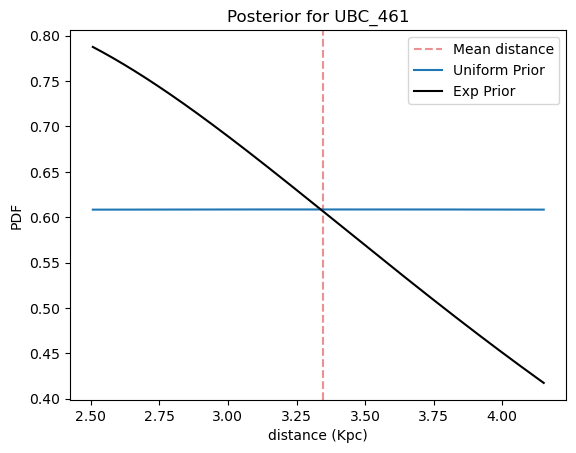

In [38]:
def posterior(clusters, stars,rng_val):
    '''Calculate the posterior for distance to a cluster
    ADJUST TO LOGSPACE
    From a random filtered cluster, sample its distance, mean and std dev
    use  Bayes' theorem to 
    
    '''
    #pick a random cluster from the cleaned dataset
    rng = np.random.default_rng(rng_val) #for reproducability
    random_cluster = rng.choice(clusters.index)
    print("My cluster is " + random_cluster)
    #obtain all the data about the cluster
    dataset = stars[stars['Name'] == random_cluster]

    parameters = clusters.loc[random_cluster]
    #convert the parallax parameters into distance space
    mean_dist = 1/parameters['Mean plx'] 
    std_dist = 1/parameters['Plx std']
    #add offset to parallax units mas
    offset = 0.029 #mas 
    dataset['Plx'] = (dataset['Plx'] + offset) 
    #create a new column of distance to source
    dataset['Distance'] = 1/dataset['Plx'] # distance to star in kilo parsec
    #for the uniform distribution
    uniform_distro = 1
    #make sure the distances are an numpy array
    distance_array = dataset['Distance'].to_numpy()
    #calculate the normal distribution for a cluster P(D| theta)

    #make a lambda array like that in episode 7 but for distance
    lam_array = np.linspace(np.min(distance_array), np.max(distance_array), num=1000)
    #make a sample of random distributions around the distance to the cluster
    #loc is the mean and scale is the standard deviation
    normal_distro = sps.norm.pdf(lam_array, loc=mean_dist, scale=std_dist)
    #the integral for a uniform prior

    
    exp_prior = realitstic_prior(d=lam_array)
    
    Pd_normal = spint.simpson(normal_distro*uniform_distro,x=lam_array)
    #repeat for the exponential prior

    
    Pd_exp = spint.simpson(normal_distro*exp_prior,x=lam_array)
    normal_post = (normal_distro*uniform_distro)/(Pd_normal)
    #exponetial distro posterior
    exp_post = (normal_distro*realitstic_prior(d=lam_array))/Pd_exp

    plt.title("Posterior for "+random_cluster)
    plt.axvline(x=mean_dist, alpha=0.5, c='tab:red', linestyle='--', label='Mean distance')
    plt.plot(lam_array, normal_post,label="Uniform Prior")
    plt.ylabel("PDF")
    plt.xlabel("distance (Kpc)")
    plt.plot(lam_array, exp_post,color='k',label="Exp Prior")
    plt.legend()
    plt.show()
    return normal_post, exp_post
normal_post, exp_post = posterior(cluster_analysis, stars,1234)

My cluster is NGC_3766


/tmp/ipykernel_2543/970412940.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['Plx'] = (dataset['Plx'] + offset)
/tmp/ipykernel_2543/970412940.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['Distance'] = 1/dataset['Plx'] # distance to star in kilo parsec


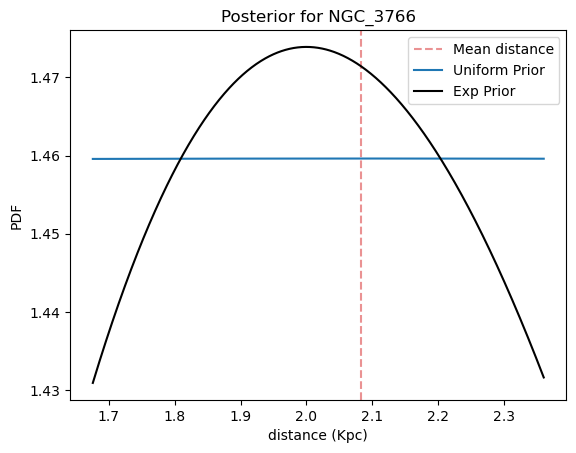

My cluster is HSC_2363


/tmp/ipykernel_2543/970412940.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['Plx'] = (dataset['Plx'] + offset)
/tmp/ipykernel_2543/970412940.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['Distance'] = 1/dataset['Plx'] # distance to star in kilo parsec


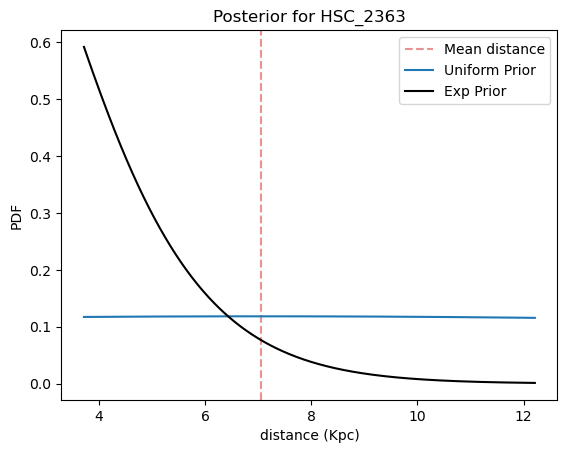

In [39]:
yeet = posterior(cluster_analysis, stars,1)
yot = posterior(cluster_analysis, stars,14)